1. Nama: Muhammad Zukri Al Walidani
2. Batch: 007
3. Phase:2

Dunia industri membutuhkan efisiensi dalam produksinya, termasuk dunia industri pertanian. Tidak jarang perusahaan harus mengeluarkan biaya tenaga kerja karena kurangnya automatisasi dan tidak jarang pula terjadi human error pada tahap produksi. Salah satunya tahap penyortiran atau grading yang merupakan bagian penting dalam menjaga kualitas bahan baku agar produk yang dihasilkan tetap terjaga kualitasnya dan lebih tahan lama. Diantara produk yang membutuhkan penyortiran seperti buah-buahan. Berikut merupakan dataset buah-buahan terdiri dari buah pisang, jeruk dan apel. Terdapat buah busuk yang tergabung diantara buah-buah yang segar oleh karena itu dibutuhkan sebuah solusi untuk memisahkan atau menyortir buah yang segar dan buah yang busuk melalui sistem automatis untuk membantu perusahaan mengefisiensikan biaya dan menjaga kualitas produksinya.

Import Pustaka

In [ ]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout


Data Loading

In [62]:
#mengkoneksikan dengan google drive tempat meletakkan data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [63]:
#masuk ke folder dataset
% cd /content/gdrive/My Drive/dataset

/content/gdrive/My Drive/dataset


In [64]:
#membuktikan lokasi berada di folder yang benar
! ls

dataset_buah  models


In [65]:
#membuktikan lokasi berada di folder yang benar
! pwd

/content/gdrive/My Drive/dataset


Eksplorasi Data

In [66]:
#memeriksa item yang ada dalam masing masing folder
for dirpath, dirnames, filenames in os.walk('dataset_buah'):
  print(f"Ada {len(dirnames)} folder dan ada {len(filenames)} gambar di dalam {dirpath}")

Ada 3 folder dan ada 0 gambar di dalam dataset_buah
Ada 6 folder dan ada 0 gambar di dalam dataset_buah/train
Ada 0 folder dan ada 1581 gambar di dalam dataset_buah/train/freshbanana
Ada 0 folder dan ada 1466 gambar di dalam dataset_buah/train/freshoranges
Ada 0 folder dan ada 2224 gambar di dalam dataset_buah/train/rottenbanana
Ada 0 folder dan ada 2342 gambar di dalam dataset_buah/train/rottenapples
Ada 0 folder dan ada 1595 gambar di dalam dataset_buah/train/rottenoranges
Ada 0 folder dan ada 1693 gambar di dalam dataset_buah/train/freshapples
Ada 6 folder dan ada 0 gambar di dalam dataset_buah/inference
Ada 0 folder dan ada 8 gambar di dalam dataset_buah/inference/freshoranges
Ada 0 folder dan ada 7 gambar di dalam dataset_buah/inference/rottenapples
Ada 0 folder dan ada 5 gambar di dalam dataset_buah/inference/rottenbanana
Ada 0 folder dan ada 7 gambar di dalam dataset_buah/inference/freshbanana
Ada 0 folder dan ada 5 gambar di dalam dataset_buah/inference/rottenoranges
Ada 0 fold

In [67]:
#melihat label pada data train
data_dir = pathlib.Path('dataset_buah/train')
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['freshapples' 'freshbanana' 'freshoranges' 'rottenapples' 'rottenbanana'
 'rottenoranges']


Exploratory Data Analysis

In [68]:
#melihat label pada data test
data_dir = pathlib.Path('dataset_buah/test')
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['freshapples' 'freshbanana' 'freshoranges' 'rottenapples' 'rottenbanana'
 'rottenoranges']


In [69]:
# mmembuat fungsi untuk melihat data
def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 3)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image Shape : {img.shape}")
  return img

Image Shape : (464, 480, 3)


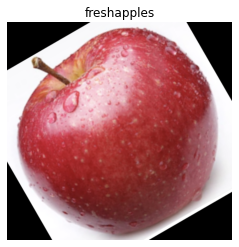

In [28]:
#melihat data random pada folder freshapples
img = view_random_image(target_dir='dataset_buah/train/',
                        target_class='freshapples')

Image Shape : (338, 400, 4)


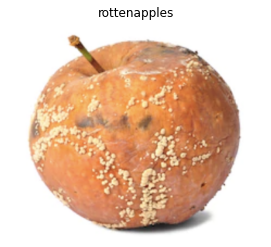

In [29]:
#melihat data random pada folder rottenapples
img = view_random_image(target_dir='dataset_buah/train/',
                        target_class='rottenapples')

Image Shape : (474, 386, 3)


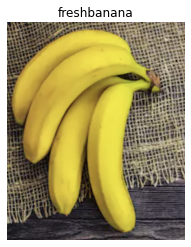

In [30]:
#melihat data random dari folder rottenapples
img = view_random_image(target_dir='dataset_buah/train/',
                        target_class='freshbanana')

Image Shape : (518, 740, 3)


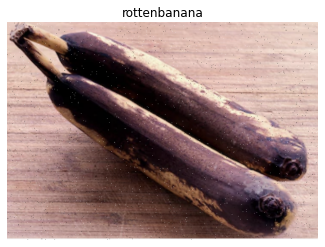

In [31]:
#melihat data di folder rottenbanana
img = view_random_image(target_dir='dataset_buah/train/',
                        target_class='rottenbanana')

Image Shape : (362, 392, 3)


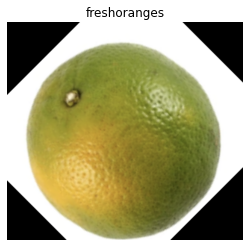

In [32]:
#melihat data di folder freshorange
img = view_random_image(target_dir='dataset_buah/train/',
                        target_class='freshoranges')

Image Shape : (496, 538, 4)


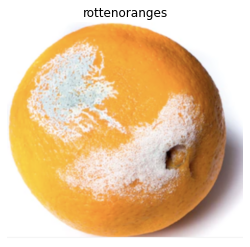

In [33]:
#melhat data di folder rottenorange
img = view_random_image(target_dir='dataset_buah/train/',
                        target_class='rottenoranges')

Insight:
1. data terdiri dari 3 jenis buah buahan yaitu jeruk, apel dan pisang.
2. Buah buahan terdiri dari dua klasifikasi yaitu buah yang busuk dan buah yang segar
3. Sudut pengambilan gambar diambil dari berbagai angle (bawah, atas, samping, miring,dan sudut lain) hal ini dimaksudkan untuk menambah variasi pengetahuan model, semakin banyak variasi maka model akan semakin fleksibel dalam memprediksi data baru nantinya. 
4. variasi juga dilakukan pada buah yang memiliki dua jenis warna seperti apel dan jeruk. terlihat bahwa pada gambar jeruk ada yang berwarna hijau dan bewarna orange. begitu pula dengan buah lainya.

Data Preprocessing

In [75]:
tf.random.set_seed(46)

# preprocessing berupa scaling image
train_datagen = ImageDataGenerator(rescale=1/255.0)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
inference_datagen = ImageDataGenerator(rescale=1/255.0)


# membuat data dengan berbagai arah untuk memberikan pengetahuan lebih untuk model
train_datagen_augmented = ImageDataGenerator(rescale=1/255.0,
                                             rotation_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)
#membuat dictonary
train_dir = 'dataset_buah/train/'
test_dir = 'dataset_buah/test/'
inference_dir = 'dataset_buah/inference/'

# pembuatan pipeline
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=50,
                                               target_size=(200, 200),
                                               class_mode='categorical',
                                               seed=46)
#augmentasi berfungsi untuk memperbanyak variasi data tapi tidak memperbanyak data
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                               batch_size=16,
                                               target_size=(200, 200),
                                               class_mode='categorical',
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=16,
                                               target_size=(200, 200),
                                               class_mode='categorical',
                                               seed=46)

inference_data = inference_datagen.flow_from_directory(inference_dir,
                                               batch_size=16,
                                               target_size=(200, 200),
                                               class_mode='categorical',
                                               seed=46)

Found 10901 images belonging to 6 classes.
Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.
Found 28 images belonging to 6 classes.


Model Definition and Model Evaluation

In [35]:
#pembuatan arsitektur base model 
model = Sequential([
                    Conv2D(16, 3, activation='relu', input_shape=[200, 200, 3]),
                    MaxPool2D(2),
                    Conv2D(64, 3, activation='relu'),
                    MaxPool2D(2),
                    Conv2D(128, 3, activation='relu'),
                    MaxPool2D(2),
                    Conv2D(128, 3, activation='relu'),
                    MaxPool2D(2),
                    MaxPool2D(2),
                    Conv2D(128, 3, activation='relu'),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(6, activation='softmax')

])

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

#base model menggunakan optimizer adam dengan loss categotical crossentropy (karena multiclass) 

In [36]:
#melihat struktur base model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 99, 99, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 97, 97, 64)        9280      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 23, 128)     

In [37]:
#trainning base model
history = model.fit(train_data_augmented,
                    epochs=10,
                    validation_data=valid_data)

Epoch 1/10
682/682 [==============================] - 2588s 4s/step - loss: 0.9014 - accuracy: 0.6498 - val_loss: 0.4436 - val_accuracy: 0.8410
Epoch 2/10
682/682 [==============================] - 182s 266ms/step - loss: 0.4190 - accuracy: 0.8480 - val_loss: 0.2467 - val_accuracy: 0.9070
Epoch 3/10
682/682 [==============================] - 179s 262ms/step - loss: 0.3359 - accuracy: 0.8818 - val_loss: 0.2790 - val_accuracy: 0.8996
Epoch 4/10
682/682 [==============================] - 179s 262ms/step - loss: 0.2745 - accuracy: 0.9002 - val_loss: 0.2907 - val_accuracy: 0.8962
Epoch 5/10
682/682 [==============================] - 177s 260ms/step - loss: 0.2543 - accuracy: 0.9098 - val_loss: 0.2795 - val_accuracy: 0.9010
Epoch 6/10
682/682 [==============================] - 178s 260ms/step - loss: 0.2153 - accuracy: 0.9229 - val_loss: 0.2098 - val_accuracy: 0.9270
Epoch 7/10
682/682 [==============================] - 177s 260ms/step - loss: 0.1884 - accuracy: 0.9314 - val_loss: 0.1320 - v

In [38]:
#membuat fungsi plot grafik
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

improve Model


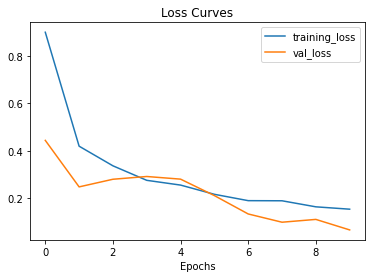

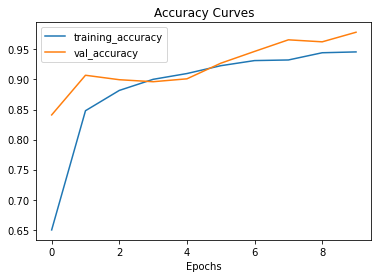

In [39]:
#model evaluasi model 3
print("improve Model")
plot_loss_curves(history)

Base model sudah terlihat cukup bagus, namun terlihat akan overvetting, penanganan dapat dilakukan dengan mengganti parameter seperti optimizer

Model Improvement

In [122]:
#pembuatan arsitektur model kedua
model = Sequential([
                    Conv2D(16, 3, activation='relu', input_shape=[200, 200, 3]),
                    MaxPool2D(2),
                    Conv2D(64, 3, activation='relu'),
                    MaxPool2D(2),
                    Conv2D(128, 3, activation='relu'),
                    MaxPool2D(2),
                    Conv2D(128, 3, activation='relu'),
                    MaxPool2D(2),
                    MaxPool2D(2),
                    Conv2D(128, 3, activation='relu'),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(6, activation='softmax')

])

model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

#model kedua menggunakan optimizer lain yaitu SGD

In [123]:
#melihat struktur model kedua
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 99, 99, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 97, 97, 64)        9280      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 23, 23, 128)     

In [124]:
#trainning model kedua
history = model.fit(train_data_augmented,
                    epochs=10,
                    validation_data=valid_data)

Epoch 1/10
682/682 [==============================] - 180s 263ms/step - loss: 1.5502 - accuracy: 0.3616 - val_loss: 1.1953 - val_accuracy: 0.5352
Epoch 2/10
682/682 [==============================] - 189s 278ms/step - loss: 1.0732 - accuracy: 0.5805 - val_loss: 0.8733 - val_accuracy: 0.6842
Epoch 3/10
682/682 [==============================] - 191s 280ms/step - loss: 0.6862 - accuracy: 0.7475 - val_loss: 0.4848 - val_accuracy: 0.8288
Epoch 4/10
682/682 [==============================] - 197s 289ms/step - loss: 0.5190 - accuracy: 0.8147 - val_loss: 0.3207 - val_accuracy: 0.8884
Epoch 5/10
682/682 [==============================] - 194s 284ms/step - loss: 0.4373 - accuracy: 0.8434 - val_loss: 0.2999 - val_accuracy: 0.8855
Epoch 6/10
682/682 [==============================] - 196s 287ms/step - loss: 0.3763 - accuracy: 0.8590 - val_loss: 0.2232 - val_accuracy: 0.9122
Epoch 7/10
682/682 [==============================] - 196s 288ms/step - loss: 0.3426 - accuracy: 0.8735 - val_loss: 0.2378 -

improve Model 2


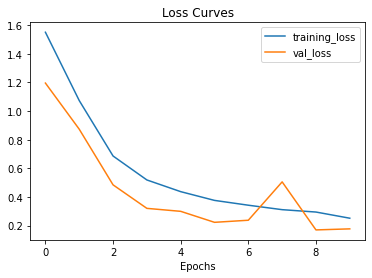

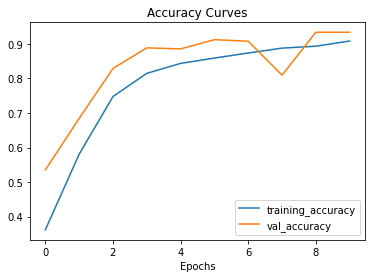

In [131]:
#model evaluation model kedua
print("improve Model 2")
plot_loss_curves(history)

Model kedua sudah terlihat tidak overfitting, namun terlihat ada bagian atau prediksi yang cukup berbeda

In [40]:
#pembuatan arstitektur model ketiga
model = Sequential([
                    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=[200, 200, 3]),
                    MaxPool2D(2,2),
                    Conv2D(64, kernel_size=(3,3), activation='relu'),
                    MaxPool2D(2,2),
                    Conv2D(64, kernel_size=(3,3), activation='relu'),
                    MaxPool2D(2,2),
                    Conv2D(64, kernel_size=(3,3), activation='relu'),
                    MaxPool2D(2,2),
                    Conv2D(64, kernel_size=(3,3), activation='relu'),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(6, activation='softmax')

])

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

#model ketiga menggunakan optimizer adam dengan penambahan kernel size

In [41]:
#melihat struktur model ketiga
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 23, 23, 64)      

In [42]:
#trainning model ketiga
history = model.fit(train_data_augmented,
                    epochs=10,
                    validation_data=valid_data)

Epoch 1/10
682/682 [==============================] - 178s 260ms/step - loss: 1.0366 - accuracy: 0.5918 - val_loss: 0.5213 - val_accuracy: 0.8343
Epoch 2/10
682/682 [==============================] - 181s 265ms/step - loss: 0.4843 - accuracy: 0.8243 - val_loss: 0.2869 - val_accuracy: 0.9033
Epoch 3/10
682/682 [==============================] - 186s 273ms/step - loss: 0.3877 - accuracy: 0.8625 - val_loss: 0.2940 - val_accuracy: 0.8973
Epoch 4/10
682/682 [==============================] - 186s 273ms/step - loss: 0.3378 - accuracy: 0.8773 - val_loss: 0.2266 - val_accuracy: 0.9133
Epoch 5/10
682/682 [==============================] - 185s 272ms/step - loss: 0.2766 - accuracy: 0.8970 - val_loss: 0.2828 - val_accuracy: 0.9059
Epoch 6/10
682/682 [==============================] - 180s 264ms/step - loss: 0.2715 - accuracy: 0.9007 - val_loss: 0.1980 - val_accuracy: 0.9333
Epoch 7/10
682/682 [==============================] - 179s 263ms/step - loss: 0.2327 - accuracy: 0.9172 - val_loss: 0.1737 -

improve Model 2


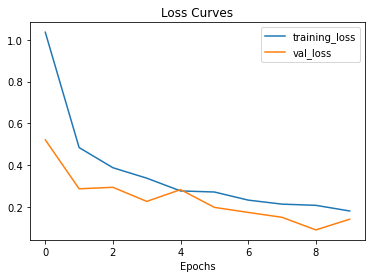

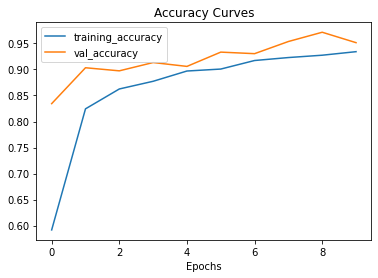

In [45]:
#model evaluation model 3
print("improve Model 2")
plot_loss_curves(history)

Model Analisis:
1. Base model sudah terlihat cukup baik namun memiliki kemungkinan mengalami overfitting
2. Model improvement kedua sudah terlihat lebih baik dari model base namun terdapat perbedaan hasil pada prediksi
3. Model improvement ketiga merupakan model yang paling baik karena tidak mengalami overfitting dan hasil cenderung stabil

Model Saving

In [47]:
#menyimpan Model
model.save('models/buah.h5')

Model Inference

In [70]:
#fungsi untuk melihat data inference
def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 2)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image Shape : {img.shape}")
  return img

Image Shape : (797, 1200, 3)


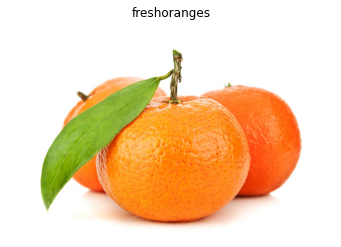

In [108]:
#melihat data inference
img3 = view_random_image(target_dir='dataset_buah/inference/',
                        target_class='freshoranges')

In [121]:
#memasukkan data baru kedalam model untuk diprediksi
model_pred = model.predict(inference_data)

model_pred1 = np.where(model_pred >= 0.7, 'Rotten', 'fresh')
model_pred1

array([['fresh', 'fresh', 'Rotten', 'fresh', 'fresh', 'fresh'],
       ['fresh', 'fresh', 'fresh', 'Rotten', 'fresh', 'fresh'],
       ['fresh', 'Rotten', 'fresh', 'fresh', 'fresh', 'fresh'],
       ['fresh', 'Rotten', 'fresh', 'fresh', 'fresh', 'fresh'],
       ['Rotten', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh'],
       ['fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh'],
       ['fresh', 'fresh', 'Rotten', 'fresh', 'fresh', 'fresh'],
       ['fresh', 'fresh', 'fresh', 'fresh', 'Rotten', 'fresh'],
       ['fresh', 'fresh', 'Rotten', 'fresh', 'fresh', 'fresh'],
       ['fresh', 'fresh', 'fresh', 'Rotten', 'fresh', 'fresh'],
       ['fresh', 'fresh', 'fresh', 'Rotten', 'fresh', 'fresh'],
       ['fresh', 'Rotten', 'fresh', 'fresh', 'fresh', 'fresh'],
       ['fresh', 'fresh', 'fresh', 'fresh', 'Rotten', 'fresh'],
       ['fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh'],
       ['fresh', 'Rotten', 'fresh', 'fresh', 'fresh', 'fresh'],
       ['fresh', 'fresh', 'fresh', 'fresh'

Kesimpulan: 
1. Sudut pengambilan gambar diambil dari berbagai angle (bawah, atas, samping, miring,dan sudut lain) hal ini dimaksudkan untuk menambah variasi pengetahuan model, semakin banyak variasi maka model akan semakin fleksibel dalam memprediksi data baru nantinya. 
2. Model yang paling baik untuk data model ke tiga
3. Model telah dapat meprediksi data baru